In [1]:
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Solow:
    ###
    # finds allocation of capital and labor across sectors
    # saving rate is given
    ###
    
    def __init__(self,
                 αKA    = 0.15,
                 αLA    = 0.55,
                 αKM    = 0.6, 
                 αLM    = 0.4,
                 XA     = 1,
                 XM     = 1,
                 L      = 1,
                 ηA     = 0.15,
                 ηM     = 0.85,
                 γA     = 0.3,
                 τR     = 0,
                 τW     = 0,
                 s      = 0.4,
                 δ      = 0.2,
                 ):
        
        self.αKA, self.αLA = αKA, αLA
        self.αKM, self.αLM = αKM, αLM
        self.XA,  self.XM  = XA , XM
        self.L             = L
        self.ηA,  self.ηM  = ηA , ηM
        self.γA            = γA
        self.τR,  self.τW  = τR , τW
        self.s             = s
        self.δ             = δ
    
    def YA_func(self, κ, K):
        ###
        # the production function for sector A
        ###
        XA, αKA, αLA = self.XA, self.αKA, self.αLA
        L            = self.L
        
        λ = self.λ_func(κ)
        
        KA = (1 - κ) * K 
        LA = (1 - λ) * L
        
        YA = XA * (KA ** αKA) * (LA ** αLA)
        return YA
    
    
    def YM_func(self, κ, K):
        ###
        # the production function for sector M
        ###
        XM, αKM, αLM = self.XM, self.αKM, self.αLM
        L            = self.L
        
        λ = self.λ_func(κ)
        
        KM = κ * K 
        LM = λ * L
        
        YM = XM * (KM ** αKM) * (LM ** αLM)
        return YM
    
    
    def λ_func(self, κ):
        ###
        # finds λ given κ
        ###
        αKA, αLA = self.αKA, self.αLA
        αKM, αLM = self.αKM, self.αLM
        ηA , ηM  = self.ηA , self.ηM
        τR , τW  = self.τR , self.τW
        
        temp = (αLA / αLM) * (αKM / αKA) * ((1 + τW) / (1 + τR)) * ((1 - κ) / κ)
        λ = (1 + temp) ** (-1)
        return λ
    
    
    def κ(self, K, κ_initial_guess):
        ###
        # equation for κ
        ###
        αKA    = self.αKA
        αKM    = self.αKM
        ηA, ηM = self.ηA, self.ηM
        γA     = self.γA
        τR     = self.τR
        s      = self.s
        
        const = (ηM / ηA) * (αKM / αKA) * (1 / (1 + τR))
        
        func = lambda κ: const * (1 - (γA / self.YA_func(κ, K)))  / (1 - s) * ((1 - κ) / κ) - 1
        
        κ = fsolve(func, κ_initial_guess)[0] 
        
        return κ
    
    def λ(self, K, κ_initial_guess):
        ###
        # finds equilibrium labor allocation
        ###
        
        κ = self.κ(K, κ_initial_guess)
        λ = self.λ_func(κ)
        
        return λ
    
    
    def YA(self, K, κ_initial_guess):
        ###
        # finds equilibrium labor allocation
        ###
        
        κ  = self.κ(K, κ_initial_guess)
        YA = self.YA_func(κ, K)
        
        return YA
    
    
    def YM(self, K, κ_initial_guess):
        ###
        # finds equilibrium labor allocation
        ###
        
        κ  = self.κ(K, κ_initial_guess)
        YM = self.YM_func(κ, K)
        
        return YM
    
    def next_K(self, K, κ_initial_guess):
        ###
        # derivative of Y_M
        ###
        s = self.s
        δ = self.δ
        
        inv  = self.YM(K, κ_initial_guess) * s
        next_K = K * (1 - δ) + inv
        
        return next_K
    
    def CM(self, K, κ_initial_guess):
        ###
        # consumption of M goods
        ###
        s = self.s
        
        CM = self.YM(K, κ_initial_guess) * (1 - s)
        
        return CM
    
    def S(self, K, κ_initial_guess):
        ###
        # Savings
        ###
        s = self.s
        
        savings  = self.YM(K, κ_initial_guess) * s
        
        return savings

In [3]:
model = Solow()

In [4]:
model.next_K(K = 1, κ_initial_guess = 0.8)

1.1145451419810244

In [18]:
def ComputePaths(model, K0, κ_initial_guess, T = 10):
    ###
    # returns dynamics of capital and allocation
    ###
    
    # create vectors
    K_vec   = np.empty(T+2)
    κ_vec   = np.empty(T+1)
    λ_vec   = np.empty_like(κ_vec)
    YM_vec  = np.empty_like(κ_vec)
    CM_vec  = np.empty_like(κ_vec)
    CA_vec  = np.empty_like(κ_vec)
    S_vec   = np.empty_like(κ_vec)
    
    # set initial values
    K_vec[0]  = K0
    κ_vec[0]  = model.κ(K0, κ_initial_guess)
    λ_vec[0]  = model.λ(K0, κ_initial_guess)
    YM_vec[0] = model.YM(K0, κ_initial_guess)
    CM_vec[0] = model.CM(K0, κ_initial_guess)
    CA_vec[0] = model.YA(K0, κ_initial_guess) # CA = YA
    S_vec[0]  = model.S(K0, κ_initial_guess)
    
    for t in range(T):
        K_vec[t+1]  = model.next_K(K_vec[t], κ_vec[t])
        κ_vec[t+1]  = model.κ(K_vec[t], κ_vec[t])
        λ_vec[t+1]  = model.λ(K_vec[t], κ_vec[t])
        YM_vec[t+1] = model.YM(K_vec[t], κ_vec[t])
        CM_vec[t+1] = model.CM(K_vec[t], κ_vec[t])
        CA_vec[t+1] = model.YA(K_vec[t], κ_vec[t])
        S_vec[t+1]  = model.S(K_vec[t], κ_vec[t])
    
    K_vec[T+1] = model.next_K(K_vec[T], κ_vec[T])
    
    CM_share_vec = CM_vec / (CA_vec + CM_vec)
    sav_rate_vec = S_vec / (YM_vec + CA_vec)
    
    return K_vec, κ_vec, λ_vec, CM_vec, CA_vec, CM_share_vec, sav_rate_vec

In [19]:
paths = ComputePaths(model, 1, 0.5, T=20)

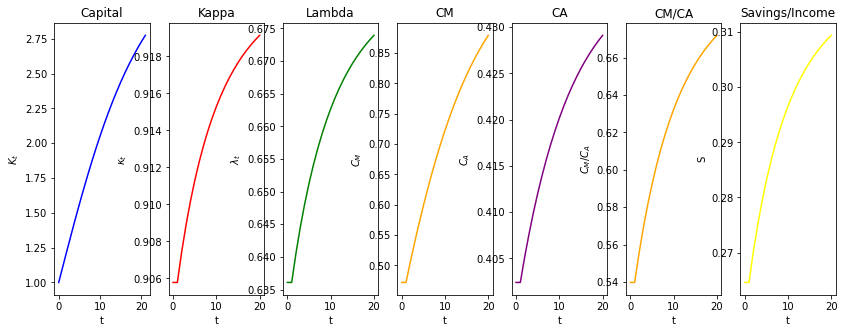

In [20]:
fig, axs = plt.subplots(1, 7, figsize=(14, 5))

colors = ['blue', 'red', 'green', 'orange', 'purple', 'orange', 'yellow']
titles = ['Capital', 'Kappa', 'Lambda', 'CM', 'CA', 'CM/CA', 'Savings/Income']
ylabels = ['$K_t$', '$\kappa_t$', '$\lambda_t$' , '$C_M$', '$C_A$', '$C_M/C_A$', 'S']

T = paths[0].size - 1
for i in range(7):
    axs[i].plot(paths[i], c=colors[i])
    axs[i].set(xlabel='t', ylabel=ylabels[i], title=titles[i])

#axs[1].scatter(T+1, 0, s=80)
#axs[1].axvline(T+1, color='k', ls='--', lw=1)

plt.show()

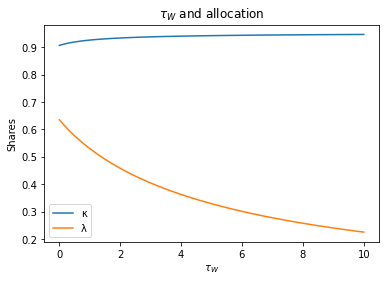

In [8]:
fig, ax = plt.subplots()
τWs     = np.linspace(1e-2, 10, 100)
κs      = np.zeros_like(τWs)
λs      = np.zeros_like(τWs)
for i, τW in enumerate(τWs):
    alloc = Solow(τW = τW)
    κs[i] = alloc.κ(K = 1, κ_initial_guess = 0.8)
    λs[i] = alloc.λ(K = 1, κ_initial_guess = 0.8)
ax.plot(τWs, κs, label = 'κ')
ax.plot(τWs, λs, label = 'λ')
ax.legend()
ax.set_xlabel(r'$\tau_W$'.format())
ax.set_ylabel(r'Shares'.format())
ax.set_title(r'$\tau_W$ and allocation'.format())
plt.show()

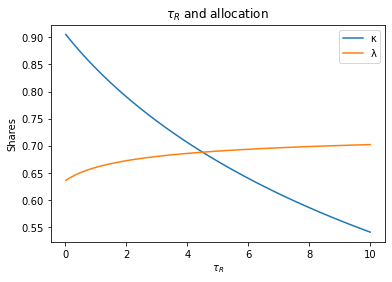

In [9]:
fig, ax = plt.subplots()
τRs     = np.linspace(1e-2, 10, 100)
κs      = np.zeros_like(τRs)
λs      = np.zeros_like(τRs)
for i, τR in enumerate(τRs):
    alloc = Solow(τR = τR)
    κs[i] = alloc.κ(K = 1, κ_initial_guess = 0.8)
    λs[i] = alloc.λ(K = 1, κ_initial_guess = 0.8)
ax.plot(τRs, κs, label = 'κ')
ax.plot(τRs, λs, label = 'λ')
ax.legend()
ax.set_xlabel(r'$\tau_R$'.format())
ax.set_ylabel(r'Shares'.format())
ax.set_title(r'$\tau_R$ and allocation'.format())
plt.show()

In [33]:
def plot_paths(model, K0, κ_initial_guess, T_arr, axs = None):

    if axs is None:
        fix, axs = plt.subplots(1, 3, figsize=(16, 4))
    ylabels = ['$K_t$', '$\kappa_t$', '$\lambda_t$']
    titles = ['Capital', 'Kappa', 'Lambda']

    for T in T_arr:
        paths = ComputePaths(model, K0, κ_initial_guess, T = T)

        for i in range(3):
            axs[i].plot(paths[i])
            axs[i].set(xlabel='t', ylabel=ylabels[i], title=titles[i])

    return paths[0], paths[1], paths[2]

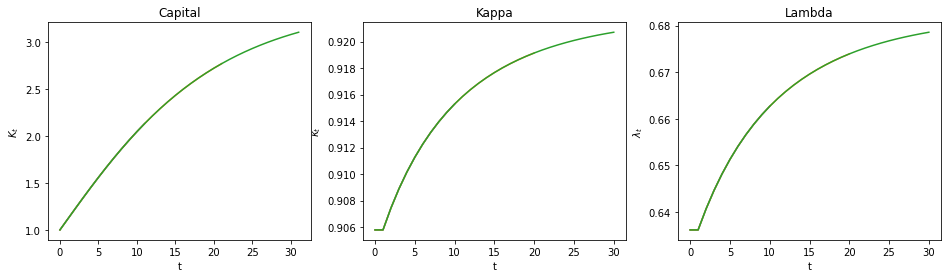

In [34]:
plot_paths(model, 1, 0.8, [10, 20, 30]);

In [58]:
def plot_paths_τR(K0, κ_initial_guess, τR_arr ,T = 10, axs = None):

    if axs is None:
        fix, axs = plt.subplots(1, 3, figsize=(16, 4))
    ylabels = ['$K_t$', '$\kappa_t$', '$\lambda_t$']
    titles = ['Capital', 'Kappa', 'Lambda']

    for τR in τR_arr:
        model = Solow(τR = τR)
        paths = ComputePaths(model, K0, κ_initial_guess, T = T)

        for i in range(3):
            axs[i].plot(paths[i], label = r'$\tau_R$ is {}'.format(τR))
            axs[i].set(xlabel='t', ylabel=ylabels[i], title=titles[i])
            axs[i].legend()

        
    return paths[0], paths[1], paths[2]

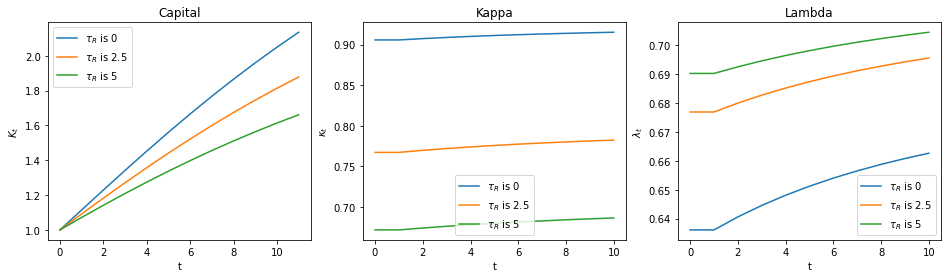

In [63]:
plot_paths_τR(1, 0.8, [0, 2.5, 5]);

In [60]:
def plot_paths_τW(K0, κ_initial_guess, τW_arr ,T = 10, axs = None):

    if axs is None:
        fix, axs = plt.subplots(1, 3, figsize=(16, 4))
    ylabels = ['$K_t$', '$\kappa_t$', '$\lambda_t$']
    titles = ['Capital', 'Kappa', 'Lambda']

    for τW in τW_arr:
        model = Solow(τW = τW)
        paths = ComputePaths(model, K0, κ_initial_guess, T = T)

        for i in range(3):
            axs[i].plot(paths[i], label = r'$\tau_W$ is {}'.format(τW))
            axs[i].set(xlabel='t', ylabel=ylabels[i], title=titles[i])
            axs[i].legend()

        
    return paths[0], paths[1], paths[2]

(array([1.        , 1.04726727, 1.09252603, 1.13574474, 1.17691458,
        1.21604586, 1.25316469, 1.28831011, 1.32153153, 1.35288646,
        1.38243861, 1.41025619]),
 array([0.94173344, 0.94173344, 0.94208622, 0.94240498, 0.94269363,
        0.94295554, 0.94319361, 0.94341037, 0.94360802, 0.94378849,
        0.94395347]),
 array([0.32875671, 0.32875671, 0.33018108, 0.33147783, 0.33266016,
        0.33373963, 0.33472643, 0.33562954, 0.33645692, 0.33721564,
        0.33791201]))

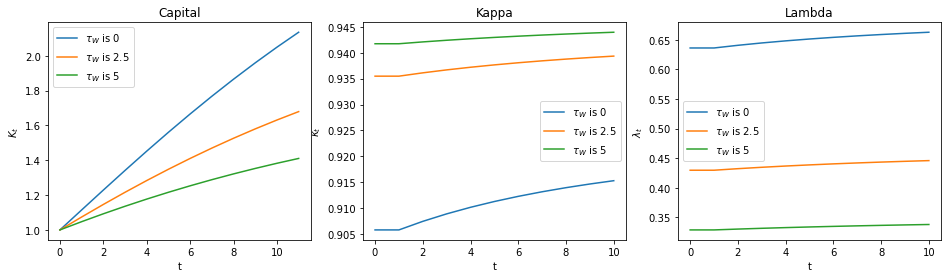

In [66]:
plot_paths_τW(1, 0.8, [0, 2.5, 5]),